In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [37]:
!python download_tables.py --seasons Fall Spring Winter Summer --years 2024 2023 2022 2021 2020 --tables stops

Fall 2024
Fall 2023
Fall 2022
Fall 2021
Fall 2020
Spring 2024
Spring 2023
Spring 2022
Spring 2021
Spring 2020
Winter 2024
Winter 2023
Winter 2022
Winter 2021
Winter 2020
Summer 2024
Summer 2023
Summer 2022
Summer 2021
Summer 2020


In [3]:
def load_and_filter_seasonal_data(year):
    seasons = ['Spring', 'Summer', 'Fall', 'Winter']
    seasonal_data = []
    for season in seasons:
        path = rf'datasets\{season}_{year}\stops.txt'
        df = pd.read_csv(path)
        filtered_df = df[df['zone_id'].str.startswith('CR', na=False)]
        seasonal_data.append(filtered_df[filtered_df['location_type'] == 1][['stop_name', 'zone_id']])
    return seasonal_data

def combine_seasonal_data(seasonal_data, year):
    combined_df = pd.concat(seasonal_data).drop_duplicates(subset='stop_name', keep='last')
    combined_df = combined_df.rename(columns={'zone_id': f'zone_{year}'})
    return combined_df

In [4]:
stations_2021 = combine_seasonal_data(load_and_filter_seasonal_data(2021), 2021)
stations_2022 = combine_seasonal_data(load_and_filter_seasonal_data(2022), 2022)
stations_2023 = combine_seasonal_data(load_and_filter_seasonal_data(2023), 2023)
stations_2024 = combine_seasonal_data(load_and_filter_seasonal_data(2024), 2024)

merged_data = stations_2021.merge(stations_2022, on='stop_name', how='outer')
merged_data = merged_data.merge(stations_2023, on='stop_name', how='outer')
merged_data = merged_data.merge(stations_2024, on='stop_name', how='outer')

merged_data['zone_change'] = (
    (merged_data['zone_2021'] != merged_data['zone_2022']) |
    (merged_data['zone_2022'] != merged_data['zone_2023']) |
    (merged_data['zone_2023'] != merged_data['zone_2024'])
)

changed_stations = merged_data[merged_data['zone_change']]

In [5]:
changed_stations

,stop_name,zone_2021,zone_2022,zone_2023,zone_2024,zone_change
9,River Works,CR-zone-1A-2,CR-zone-2,CR-zone-2,CR-zone-2,True
10,Lynn,CR-zone-1A-2,CR-zone-2,CR-zone-2,CR-zone-2,True
47,Foxboro,CR-zone-4,CR-zone-Event,CR-zone-4,CR-zone-4,True
138,Quincy Center,CR-zone-1A-1,CR-zone-1,CR-zone-1,CR-zone-1,True
141,Pawtucket/Central Falls,NaN,NaN,CR-zone-8,CR-zone-8,True
142,Oak Grove,NaN,NaN,CR-zone-1A,CR-zone-1A,True
143,Lynn Interim,NaN,NaN,NaN,CR-zone-2,True


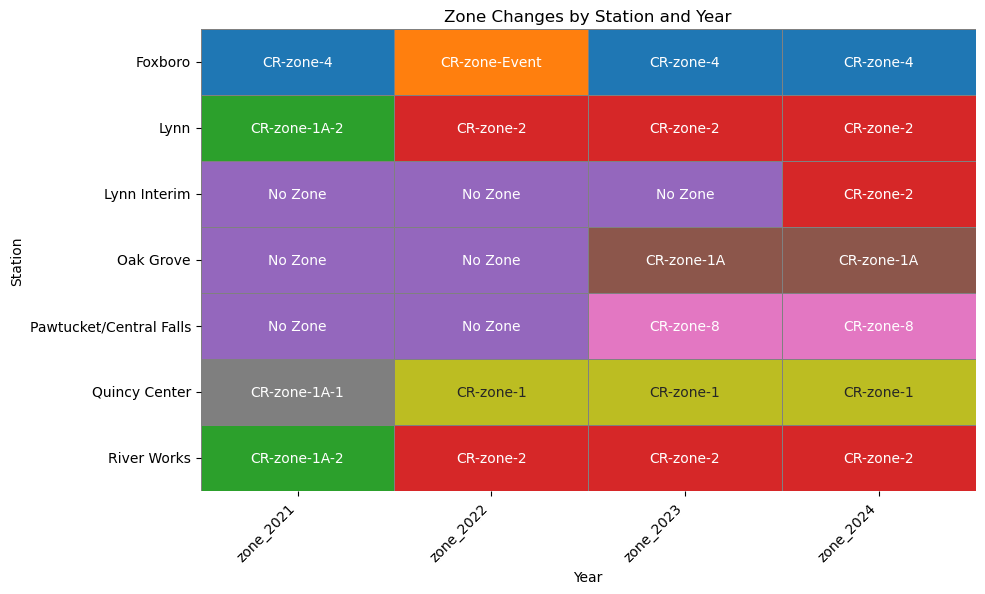

In [6]:
df = changed_stations.drop(columns=['zone_change']).fillna("No Zone")
df_melted = df.melt(id_vars='stop_name', var_name='year', value_name='zone_id')

zone_pivot = df_melted.pivot(index='stop_name', columns='year', values='zone_id')
zone_mapping = {zone: idx for idx, zone in enumerate(zone_pivot.stack().unique())}
zone_pivot_encoded = zone_pivot.replace(zone_mapping)
color_palette = sns.color_palette("tab10", n_colors=len(zone_mapping))

plt.figure(figsize=(10, 6))
sns.heatmap(zone_pivot_encoded, annot=zone_pivot, cmap=color_palette, cbar=False, fmt='',
            linewidths=0.5, linecolor='gray')
plt.title("Zone Changes by Station and Year")
plt.xlabel("Year")
plt.ylabel("Station")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

| Zone	| One-way |	Reduced One-way | Monthly Pass | Monthly mTicket |
| ----- | ------- | --------------- | ------------ | --------------- |
| Zone 1A |	$2.40 |	$1.10 |	$90.00 | $80.00 |
| Zone 1 | $6.50 | $3.25 | $214.00 | $204.00 |
| Zone 2 | $7.00 | $3.50 | $232.00 | $222.00 |
| Zone 3 | $8.00 | $4.00 | $261.00 | $251.00 |
| Zone 4 | $8.75 | $4.25 | $281.00 | $271.00 |
| Zone 5 | $9.75 | $4.75 | $311.00 | $301.00 |
| Zone 6 | $10.50 | $5.25 | $340.00 | $330.00 |
| Zone 7 | $11.00 | $5.50 | $360.00 | $350.00 |
| Zone 8 | $12.25 | $6.00 | $388.00 | $378.00 |
| Zone 9 | $12.75 | $6.25 | $406.00 | $396.00 |
| Zone 10 | $13.25 | $6.50 | $426.00 | $416.00 |

#### We can see a consistency in the fare zones from 2022 for all stations except Foxboro